# Collaboration and Competition

---

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
from collections import deque
import json

from matplotlib import pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
#env = UnityEnvironment(file_name="../Tennis_Windows_x86_64/Tennis.exe")
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]
print(brain)

TennisBrain
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [6]:
agent = Agent(state_size, action_size, num_agents, random_seed=0)

In [7]:
def ddpg(n_episodes=3000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations            # get the current state
        score = np.zeros(num_agents)

        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if np.any(done):
                break
        
        score = np.max(score)
        scores_deque.append(score)
        scores.append(score)

        if i_episode % 500 == 0:
            print('\rEpisode {}\tAverage score: {:.2f}\tScore {:.2f}\n'.format(i_episode, 
                                                                               np.mean(scores_deque), 
                                                                         score), end="")
        else:
            print('\rEpisode {}\tAverage score: {:.2f}\tScore {:.2f}'.format(i_episode, 
                                                                             np.mean(scores_deque), 
                                                                         score), end="")
            
            
        avg_score = np.mean(scores_deque)
        if (avg_score >= 0.5) and (avg_score > max_score):          
            
            print('\nEpisode {}\tAverage score: {:.2f}\tSaving checkpoint'.format(i_episode, avg_score))
            if max_score == -np.Inf:
                print('\n\nEnvironment solved in %d episodes\n' % i_episode)
            
            max_score = avg_score
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
            # save scores and break/continue as desired
            with open('scores.json', 'w') as f:
                json.dump(scores, f)
            f.close()
            #break
            
    return scores

scores = ddpg()

Episode 500	Average score: 0.01	Score 0.10
Episode 888	Average score: 0.51	Score 1.20
Episode 888	Average score: 0.51	Saving checkpoint


Environment solved in 888 episodes

Episode 889	Average score: 0.51	Score 0.29
Episode 889	Average score: 0.51	Saving checkpoint
Episode 892	Average score: 0.51	Score 0.50
Episode 892	Average score: 0.51	Saving checkpoint
Episode 893	Average score: 0.52	Score 1.10
Episode 893	Average score: 0.52	Saving checkpoint
Episode 895	Average score: 0.52	Score 0.29
Episode 895	Average score: 0.52	Saving checkpoint
Episode 896	Average score: 0.54	Score 1.79
Episode 896	Average score: 0.54	Saving checkpoint
Episode 897	Average score: 0.54	Score 0.40
Episode 897	Average score: 0.54	Saving checkpoint
Episode 898	Average score: 0.54	Score 0.20
Episode 898	Average score: 0.54	Saving checkpoint
Episode 904	Average score: 0.54	Score 0.60
Episode 904	Average score: 0.54	Saving checkpoint
Episode 906	Average score: 0.54	Score 0.20
Episode 906	Average score: 0.54	Saving 

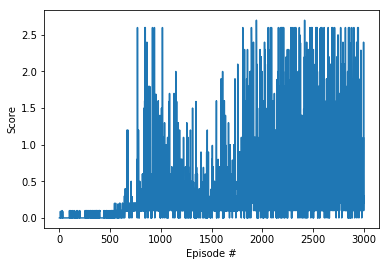

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores))+1, scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

### 3. Test the trained agent

### 4. Close environment

In [9]:
env.close()